In [56]:
# загружаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures
import category_encoders as ce
from sklearn import model_selection
from sklearn import feature_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn import ensemble
import pickle
import xgboost as xgb
import optuna

In [5]:
# загружаем исходные данные
data = pd.read_csv('data.csv')

In [6]:
# выделяем в отдельные столбцы признаки, спрятанные в словарях homefacts and schools

# смотрим, что представляет из себя признак homefacts:

print(data.homeFacts[0])

# выделяем 7 признаков из homefacts
data['Year built'] = data['homeFacts'].apply(lambda x: eval(x)['atAGlanceFacts'][0]['factValue'])
data['Remodeled year'] = data['homeFacts'].apply(lambda x: eval(x)['atAGlanceFacts'][1]['factValue'])
data['Heating'] = data['homeFacts'].apply(lambda x: eval(x)['atAGlanceFacts'][2]['factValue'])
data['Cooling'] = data['homeFacts'].apply(lambda x: eval(x)['atAGlanceFacts'][3]['factValue'])
data['Parking'] = data['homeFacts'].apply(lambda x: eval(x)['atAGlanceFacts'][4]['factValue'])
data['lotsize'] = data['homeFacts'].apply(lambda x: eval(x)['atAGlanceFacts'][5]['factValue'])
data['Price/sqft'] = data['homeFacts'].apply(lambda x: eval(x)['atAGlanceFacts'][6]['factValue'])

{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}


In [7]:
# смотрим, что представляет из себя признак schools:

data['schools'][0]

# выделяем признак distance to schools из schools (остальные признаки сложно интерпретировать)
data['Sch_distance'] = data['schools'].apply(lambda x: str(eval(x)[0]['data']['Distance']))

In [8]:
# теперь, когда все признаки на месте, начинаем работать с пропусками, сначала с явными:
data.isnull().sum()

status             39918
private pool      373004
propertyType       34733
street                 2
baths             106338
homeFacts              0
fireplace         274070
city                  34
schools                0
sqft               40577
zipcode                0
beds               91282
state                  0
stories           150715
mls-id            352243
PrivatePool       336874
MlsId              66880
target              2481
Year built          3613
Remodeled year     26569
Heating             3533
Cooling             3533
Parking             3533
lotsize            28388
Price/sqft         58553
Sch_distance           0
dtype: int64

In [9]:
# в некоторых признаках пропуски могут быть обозначены пустыми строками или другим способом

# проверяем на скрытые пропуски признак Year built
regex_year_built = '\d{4}'
data['Year built'] = data['Year built'].str.findall(regex_year_built).str.get(0)
data['Year built'].isnull().sum()

63598

In [10]:
# проверяем на скрытые пропуски признак Remodeled year
regex_remodeled_year = '\d{4}'
data['Remodeled year'] = data['Remodeled year'].str.findall(regex_remodeled_year).str.get(0)
data['Remodeled year'].isnull().sum()

226380

In [11]:
# проверяем на скрытые пропуски признак Heating
regex_heating = '\w+'
data['Heating'] = data['Heating'].str.replace('No Data', '').str.findall(regex_heating).str.get(0)
data['Heating'].isnull().sum()

117943

In [12]:
# проверяем на скрытые пропуски признак Cooling
regex_heating = '\w+'
data['Cooling'] = data['Cooling'].str.replace('No Data', '').str.replace('None', '').str.findall(regex_heating).str.get(0)
data['Cooling'].isnull().sum()

141973

In [13]:
# проверяем на скрытые пропуски признак Parking
regex_parking = '\w+'
data['Parking'] = data['Parking'].str.replace('No Data', '').str.replace('None', '').str.findall(regex_parking).str.get(0)
data['Parking'].isnull().sum()

191120

In [14]:
# проверяем на скрытые пропуски признак lotsize
regex_lotsize = '\w+'
data['lotsize'] = data['lotsize'].str.replace('No Data', '').str.replace('-- sqft lot', '').str.findall(regex_lotsize).str.get(0)
data['lotsize'].isnull().sum()

95855

In [15]:
# проверяем на скрытые пропуски признак Price/sqft
regex_Price_sqft = '\w+'
data['Price/sqft'] = data['Price/sqft'].str.replace('No Data', '').str.replace('No Info', '').str.findall(regex_Price_sqft).str.get(0)
data['Price/sqft'].isnull().sum()

65933

In [16]:
# проверяем на скрытые пропуски признак 'Sch_distance'
data.loc[data['Sch_distance'] == '[]', 'Sch_distance'] = np.nan
data['Sch_distance'].isnull().sum()

4284

In [17]:
# проверяем на скрытые пропуски признак 'sqft'
data['sqft'] = data['sqft'].str.replace('\D+', '', regex = True)
regex_sqft = '(\d+)'
data['sqft'] = data['sqft'].str.findall(regex_sqft).str.get(0)
data['sqft'].isnull().sum()

41397

In [18]:
# пропуски в sqft можно частично восстановить по Price/sqft и target

# переводим признаки в формат Int64
regex_Price_sqft_2 = '(\d+)'
data['Price/sqft'] = data['Price/sqft'].str.replace('\D+', '', regex = True).str.findall(regex_Price_sqft_2).str.get(0).astype('Int64')

data['target'] = data[~data['target'].isnull()]['target'].str.replace('\D+', '', regex = True).astype('Int64')

# вычисляем (где возможно) на их основе sqft для пропущенных значений:

non_null_filter = (~data['target'].isnull()) & (~data['Price/sqft'].isnull())
data['sqft'] = data['sqft'].fillna(round(data[non_null_filter]['target'] / data[non_null_filter]['Price/sqft'])).astype(str)

regex_sqft_2 = '(\d+)'
data['sqft'] = data['sqft'].str.findall(regex_sqft_2).str.get(0).astype('Int64')
data['sqft'].isnull().sum()



40139

In [19]:
# пропуски в city можно восстановить по индексу
data['city'] = data['city'].str.lower().str.replace('\W+', '', regex = True)
data['city'] = data['city'].fillna(
    data.groupby('zipcode')['city'].transform(lambda x: x.mode()[0]))

data['city'].isnull().sum()

0

In [20]:
# избавляемся от дубликатов
print(data.duplicated().sum())
data = data.drop_duplicates()

50


In [21]:
# оцениваем долю пропусков для каждого признака
data.isnull().sum()/data.shape[0]

status            0.105843
private pool      0.988914
propertyType      0.092097
street            0.000005
baths             0.281883
homeFacts         0.000000
fireplace         0.726591
city              0.000000
schools           0.000000
sqft              0.106360
zipcode           0.000000
beds              0.241966
state             0.000000
stories           0.399520
mls-id            0.933865
PrivatePool       0.893115
MlsId             0.177308
target            0.006576
Year built        0.168550
Remodeled year    0.600135
Heating           0.312628
Cooling           0.376348
Parking           0.506654
lotsize           0.254129
Price/sqft        0.174762
Sch_distance      0.011359
dtype: float64

In [22]:
# удаляем признаки, где больше 30% пропусков(private pool, fireplace, stories, mls-id, PrivatePool, Remodeled year, Heating, Cooling, Parking)
# удаляем признаки, где слишком много уникальных значений (street, zipcode, MlsId )
# удаляем признак, который потенциально содержит утечку (Price/sqft)
# удаляем также признаки beds, baths и lotzise, т.к. они сильно засорены непонятными значениями
# удаляем признаки, в которых содержались словари с другими признаками (homeFacts, schools )

cols_to_remove = ['private pool', 'fireplace', 'stories', 'mls-id', 'PrivatePool',
                  'Remodeled year', 'Heating', 'Cooling', 'Parking', 'street', 'zipcode', 'MlsId',
                  'Price/sqft',
                  'beds', 'baths','lotsize',
                  'homeFacts', 'schools']
data = data.drop(cols_to_remove, axis = 1)

# в сотавшихся признаках удаляем строки с пропусками
data = data.dropna()

data.shape

(251787, 8)

In [23]:
# преобразуем признак status

# для начала уменьшаем кол-во уникальных значений путем преобрахований над строками
data['status'] = data['status'].str.lower()
data['status'] = data['status'].str.replace('\W+', ' ', regex=True)

# смотрим 20 наиболее часто втречающихся значений для признака
print(data['status'].value_counts().nlargest(20))

# создаем функцию, которая будет задавать 5 значений для данного признака
def get_status(x):
    if x == 'for sale':
        return 'for sale'
    elif x == 'active' or x == 'a active':
        return 'active'
    elif x == 'foreclosure' or x == 'foreclosed' or x == 'pre foreclosure' or x == 'pre foreclosure auction':
        return 'foreclosure'
    elif x == 'new construction' or x == 'new':
        return 'new'
    else:
        return 'other'

data['status'] = data['status'].apply(get_status)
data['status'].value_counts()

for sale                   165241
active                      59391
foreclosure                  5751
new construction             4664
pending                      4204
pre foreclosure              1576
p                            1444
under contract show          1098
pre foreclosure auction       976
 auction                      794
under contract showing        756
active under contract         710
under contract                665
contingent                    549
price change                  425
new                           419
a active                      385
for rent                      369
auction                       364
foreclosed                    253
Name: status, dtype: int64


for sale       165241
active          59776
other           13131
foreclosure      8556
new              5083
Name: status, dtype: int64

In [24]:
# преобразуем признак propertyType

# для начала уменьшаем кол-во уникальных значений путем преобрахований над строками
data['propertyType'] = data['propertyType'].str.lower()
data['propertyType'] = data['propertyType'].str.replace('\W+', ' ', regex=True)

# смотрим 20 наиболее часто втречающихся значений для признака
print(data['propertyType'].value_counts().nlargest(30))

# создаем функцию, которая будет задавать 6 значений для данного признака
def get_propertyType(x):
    if x == 'single family home' or x == 'single family' or x == 'traditional' or x == 'single detached traditional' or x == 'single detached' or  x == 'detached one story' or x == 'detached two story':
        return 'single_family'
    elif x == 'condo' or x == 'townhouse' or x == 'multi family' or x == 'condo townhome row home co op' or x == 'coop' or x == 'multi family home' or x == 'cooperative':
        return 'multi_family'
    elif x == 'mobile manufactured' or x == 'mfd mobile home':
        return 'mobile'
    elif x == 'lot land' or x == 'land':
        return 'land'
    elif x == 'apartment':
        return 'apartment'
    else:
        return 'other'

data['propertyType'] = data['propertyType'].apply(get_propertyType)
data['propertyType'].value_counts()

single family home               108757
single family                     37434
condo                             31032
townhouse                         13176
multi family                       9124
condo townhome row home co op      7385
traditional                        5831
lot land                           3271
coop                               2855
mobile manufactured                2259
ranch                              1709
high rise                          1621
single detached traditional        1580
contemporary                       1522
detached one story                 1482
multi family home                  1475
1 story                            1164
colonial                           1036
contemporary modern                 982
2 stories                           838
mfd mobile home                     784
single detached                     751
land                                638
detached two story                  595
apartment                           591


single_family    156430
multi_family      65388
other             22426
land               3909
mobile             3043
apartment           591
Name: propertyType, dtype: int64

In [25]:
# Переводим признак Year built в числовой формат
data['Year built'] = data['Year built'].astype("Int64")

# Вычмсляем среднее расстояние до школ, переводим в числовой формат
data['Sch_distance'] = data['Sch_distance'].str.replace('mi', '').str.replace(' ', '').str.replace('[', '').str.replace(']', '').str.replace("'", "")
data['Sch_distance'] = data['Sch_distance'].str.split(',')
data['Sch_distance'] = data['Sch_distance'].apply (lambda x: np.round(np.mean(list(map(float, x))),2))

C:\Users\Asus-PC\AppData\Local\Temp\ipykernel_17976\2102351334.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Sch_distance'] = data['Sch_distance'].str.replace('mi', '').str.replace(' ', '').str.replace('[', '').str.replace(']', '').str.replace("'", "")


In [26]:
# Оцениваем распределение числовых признаков
numeric_features = ['sqft', 'target', 'Year built', 'Sch_distance']
data[numeric_features].describe()



,sqft,target,Year built,Sch_distance
count,2.517870e+05,2.517870e+05,251787.000000,251787.000000
mean,7.986890e+03,6.541929e+05,1978.258476,2.567657
std,1.829194e+06,1.780665e+06,35.835566,6.665426
min,0.000000e+00,1.000000e+00,1057.000000,0.020000
25%,1.282000e+03,2.089975e+05,1955.000000,1.000000
50%,1.824000e+03,3.399000e+05,1984.000000,1.640000
75%,2.632000e+03,5.999500e+05,2006.000000,2.900000
max,7.959794e+08,1.650000e+08,5599.000000,1590.830000


In [27]:
#удаляем выбросы, руководствуясь сперва здравым смыслом:
# удаляем жилье с площадью меньше 350 кв.футов
data = data[data['sqft'] >= 350]

# удаляем жилье со стоимостью менее 15 000 $
data = data[data['target'] >= 15000]

# удаляем жилье, построенное после 2019 г:
data = data[data['Year built'] <= 2019]

## далее опредяем выбросы по методу Тьюки
# верхнюю границу выбросов площади определяем по методу Тьюки:
IQR_sqft = data['sqft'].quantile(0.75) - data['sqft'].quantile(0.25)
data = data[(data['sqft'] <= data['sqft'].quantile(0.75) + 1.5*IQR_sqft)]

# верхнюю границу выбросов по стоимости определяем по методу Тьюки:
IQR_target = data['target'].quantile(0.75) - data['target'].quantile(0.25)
data = data[(data['target'] <= data['target'].quantile(0.75) + 1.5*IQR_target)]

# нижнюю границу выбросов по году постройки определяем по методу Тьюки:
IQR_year = data['Year built'].quantile(0.75) - data['Year built'].quantile(0.25)
data = data[data['Year built'] >= data['Year built'].quantile(0.25) - 1.5*IQR_year]

# нижнюю и верхнюю границы выбросов по среднему расстоянию от школ определяем по методу Тьюки:
IQR_s_distance = data['Sch_distance'].quantile(0.75) - data['Sch_distance'].quantile(0.25)
data = data[(data['Sch_distance'] >= data['Sch_distance'].quantile(0.25) - 1.5*IQR_s_distance) & (data['Sch_distance'] <= data['Sch_distance'].quantile(0.75) + 1.5*IQR_s_distance)]



# визуализируем распределение очищенных количественных признаков

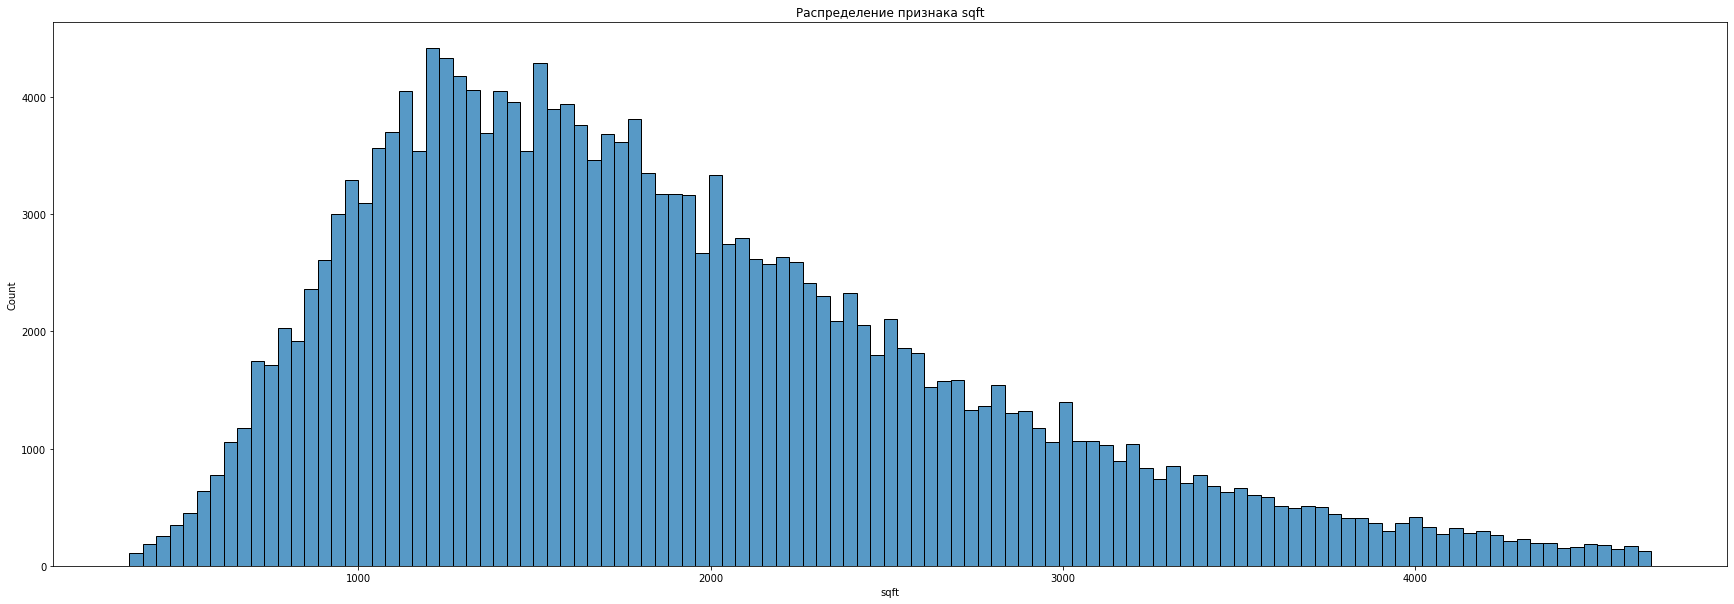

In [28]:
figure = plt.figure(figsize = (30, 10))

histplot = sns.histplot(x = data['sqft'])
histplot.set_title('Распределение признака sqft');

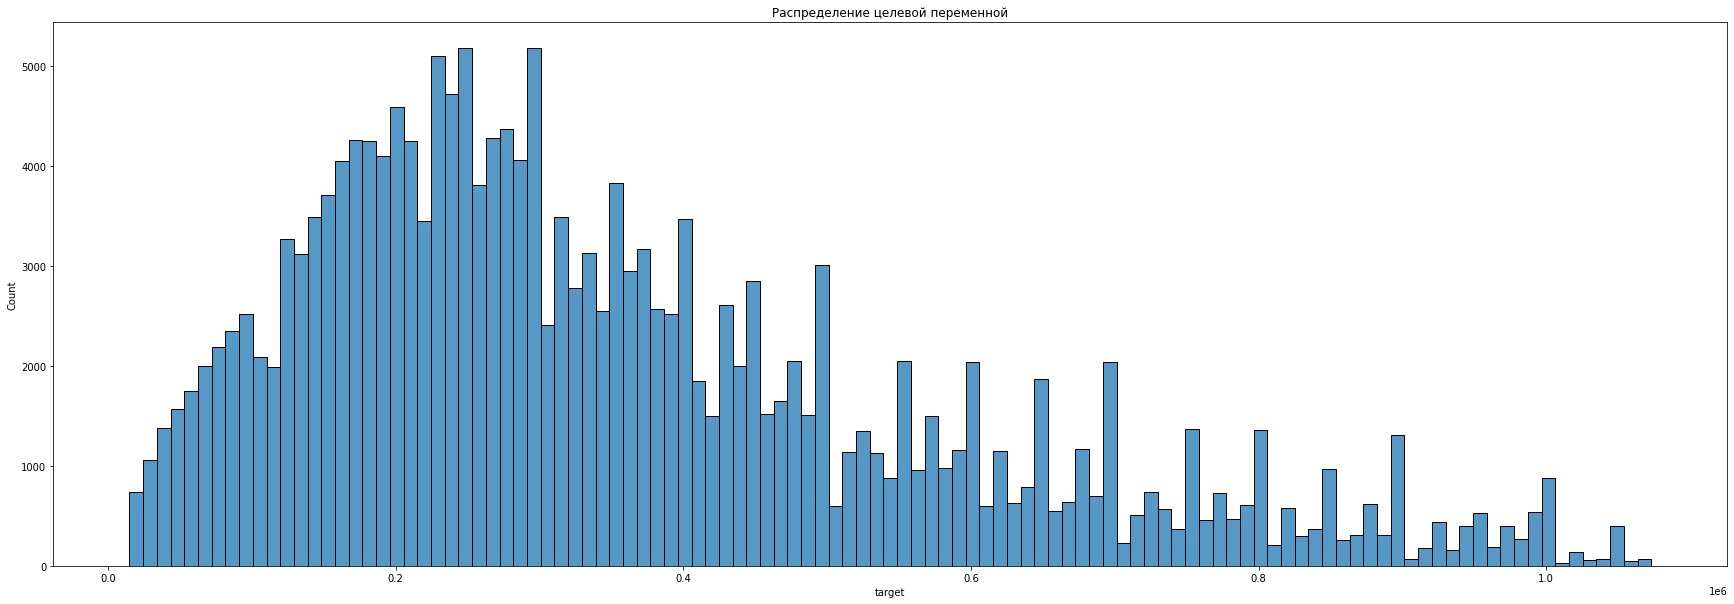

In [29]:
figure = plt.figure(figsize = (30, 10))

histplot = sns.histplot(x = data['target'])
histplot.set_title('Распределение целевой переменной');

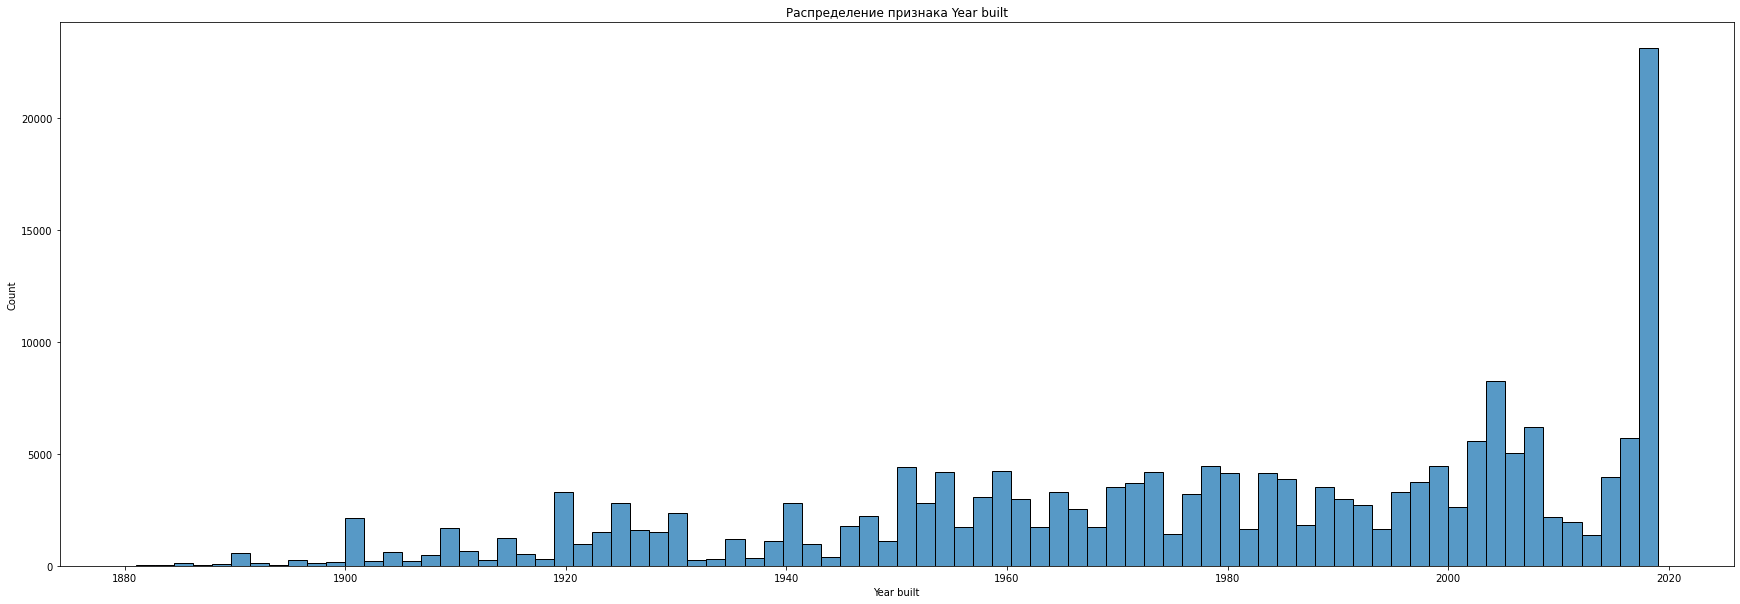

In [30]:
figure = plt.figure(figsize = (30, 10))

histplot = sns.histplot(x = data['Year built'])
histplot.set_title('Распределение признака Year built');

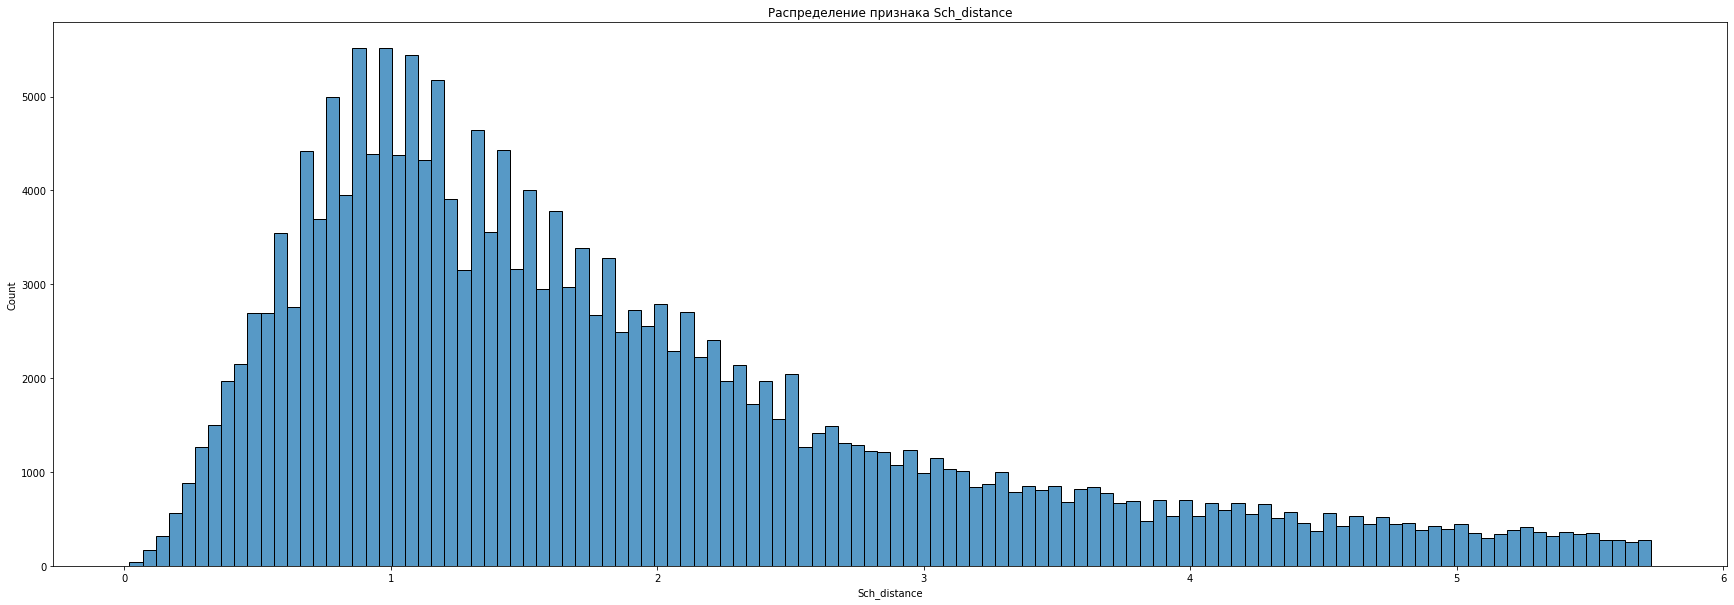

In [31]:
figure = plt.figure(figsize = (30, 10))

histplot = sns.histplot(x = data['Sch_distance'])
histplot.set_title('Распределение признака Sch_distance');

### Исходя из распределения количественных признаков, имеет смысл логарифмировать целевую переменную (см.ниже)

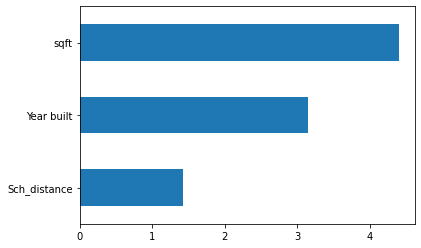

In [32]:
# Оценим вклад количественных признаков в предсказание целевой переменной
from sklearn.feature_selection import f_classif # anova

numeric_features = ['sqft', 'Year built', 'Sch_distance']
imp_num = pd.Series(f_classif(data[numeric_features], data['target'])[0], index = numeric_features)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

### вывод: наибольший вклад в предсказание целевой переменной вносит признак sqft

In [33]:
# оцениваем количественные характеристики категориальных признаков
categorical_features = ['status', 'propertyType', 'city', 'state']

data[categorical_features].describe()

,status,propertyType,city,state
count,193637,193637,193637,193637
unique,5,6,1441,34
top,for sale,single_family,houston,TX
freq,127092,124093,13468,45045


In [34]:
# для сокращения числа уникальных значений признака state, оставим только те штаты, для которых есть не менее 100 наблюдений, остальные объединим в категорию other
states_summary = data.groupby('state')['state'].count()

selected_states = []
for state in states_summary.index:
  if states_summary[state] >=100:
    selected_states.append(state)
print(len(selected_states))

data['state'] = data['state'].apply(lambda x: x if x in selected_states else 'other')

27


In [35]:
# для сокращения числа уникальных значений признака city, оставим только те города, для которых есть не менее 100 наблюдений, остальные объединим в категорию other
city_summary = data.groupby('city')['city'].count()

selected_cities = []
for city in city_summary.index:
  if city_summary[city] >=100:
    selected_cities.append(city)
print(len(selected_cities))

data['city'] = data['city'].apply(lambda x: x if x in selected_cities else 'other')

248


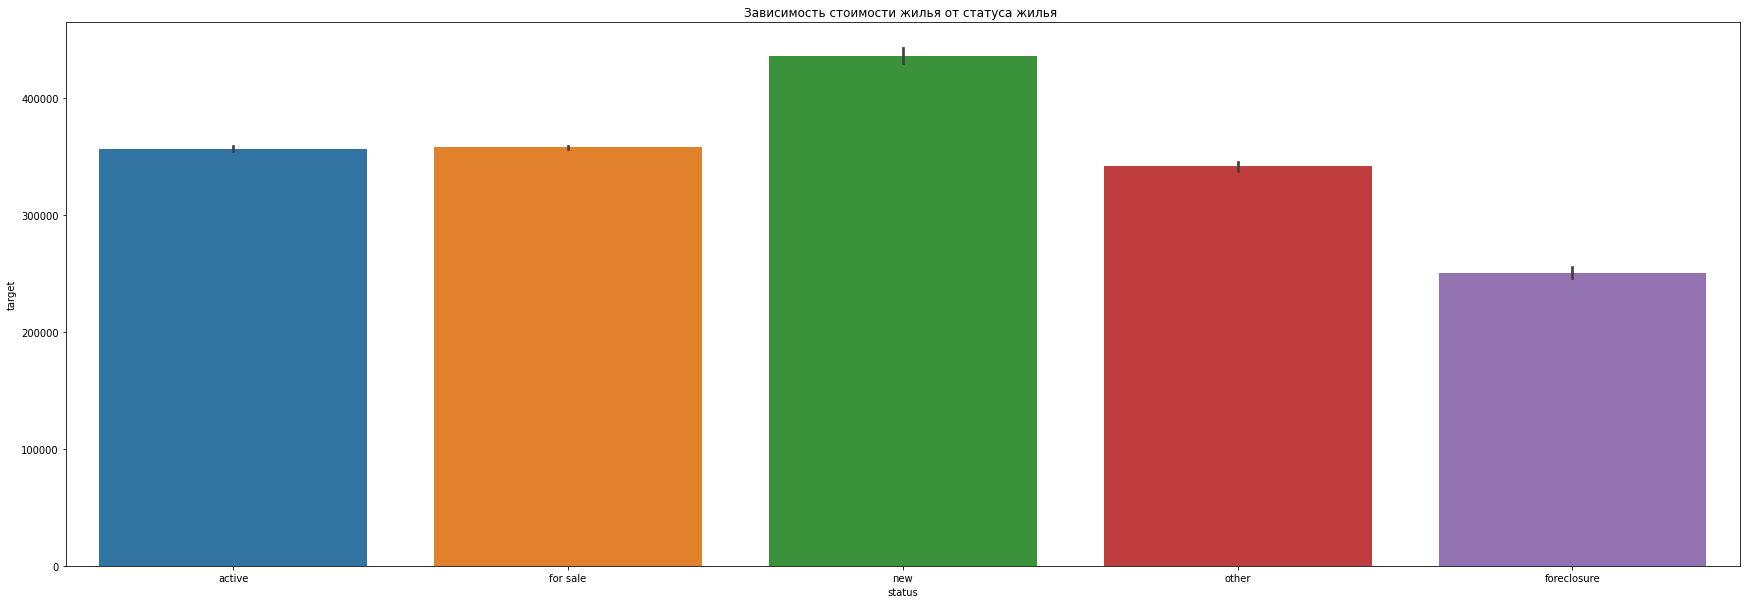

In [36]:
# визуализируем зависимость целевой переменной от статуса жилья
figure = plt.figure(figsize = (30, 10))

barplot = sns.barplot(x = data['status'], y = data['target'])
barplot.set_title('Зависимость стоимости жилья от статуса жилья ');

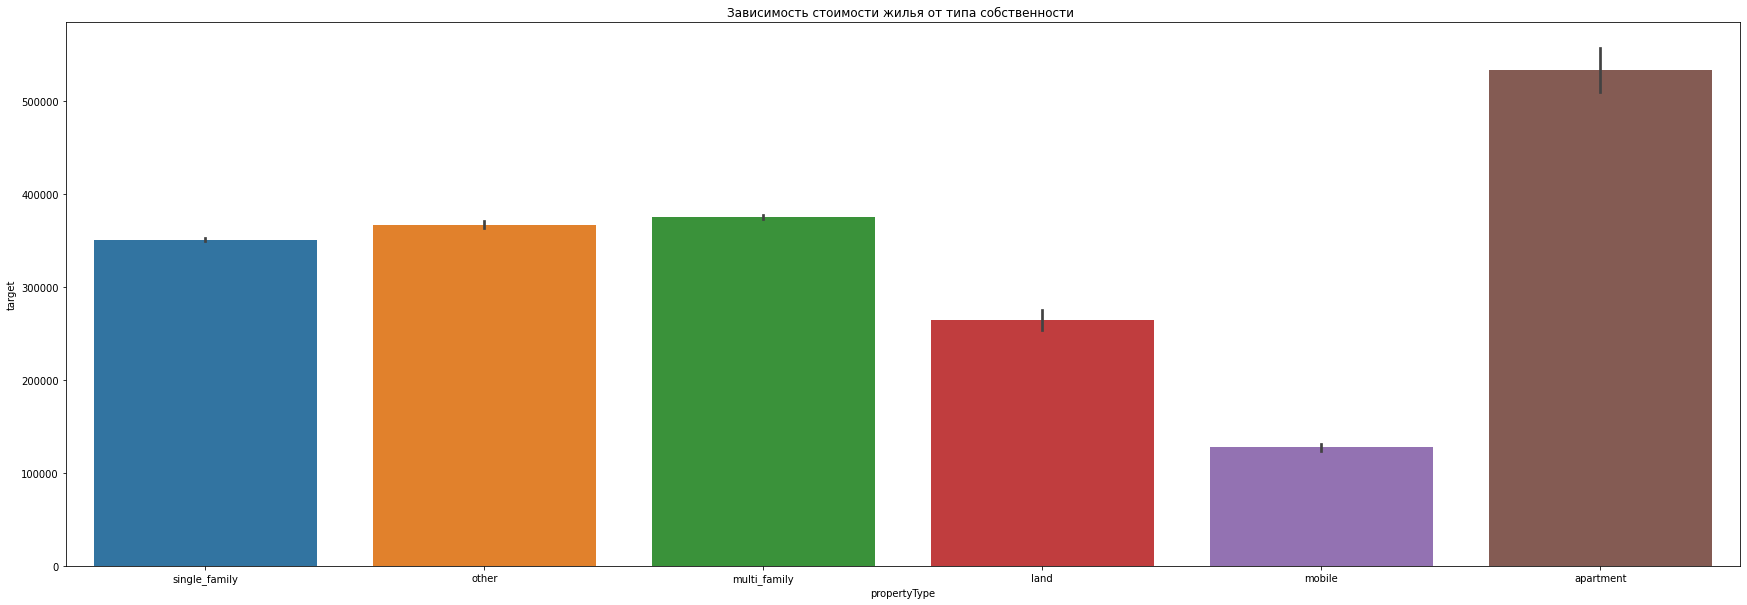

In [37]:
# визуализируем зависимость целевой переменной от типа собственности
figure = plt.figure(figsize = (30, 10))

barplot = sns.barplot(x = data['propertyType'], y = data['target'])
barplot.set_title('Зависимость стоимости жилья от типа собственности ');

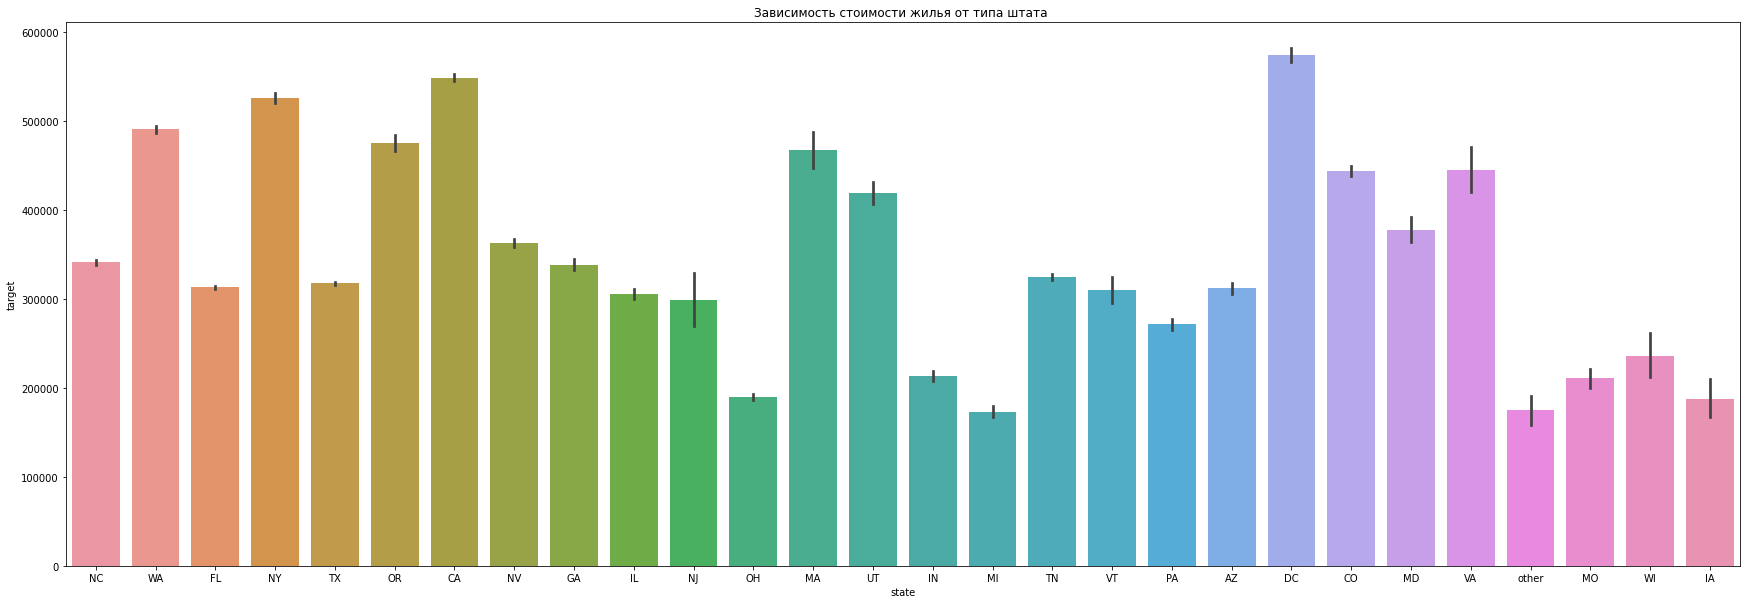

In [38]:
# визуализируем зависимость целевой переменной от штата
figure = plt.figure(figsize = (30, 10))

barplot = sns.barplot(x = data['state'], y = data['target'])
barplot.set_title('Зависимость стоимости жилья от типа штата ');

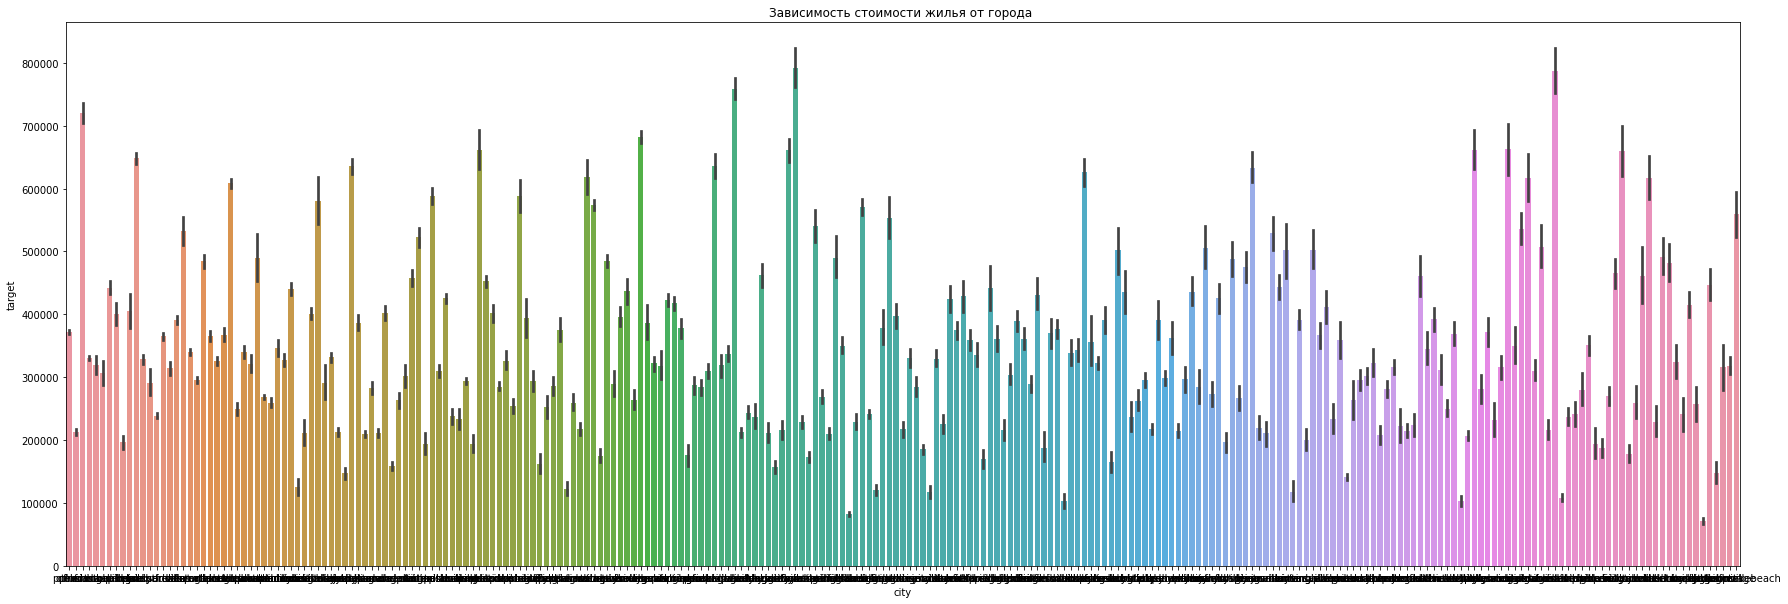

In [39]:
# визуализируем зависимость целевой переменной от города
figure = plt.figure(figsize = (30, 10))

barplot = sns.barplot(x = data['city'], y = data['target'])
barplot.set_title('Зависимость стоимости жилья от города ');

### все отобранные категориальные признаки влияют на целевую переменную

In [40]:
# Закодируем с помощью OneHotEncode признаки status и propertyType
one_hot_encoder = OneHotEncoder(drop='first')
one_hot_array = one_hot_encoder.fit_transform(data[['status', 'propertyType']]).toarray() #onehot массив
cols_name = one_hot_encoder.get_feature_names_out() #имена новых столбцов
data_onehot = pd.DataFrame(one_hot_array, columns=cols_name) #onehot data frame
print('С помощью однократного кодирования получено {} новых столбцов'.format(data_onehot.shape[1]))

#Добавляем новые признаки в таблицу данных

data = pd.concat(
    [data.reset_index(drop=True).drop(['status', 'propertyType'], axis=1), data_onehot],
    axis=1
)
print('Shape of data: {}'.format(data.shape))

С помощью однократного кодирования получено 9 новых столбцов
Shape of data: (193637, 15)


In [41]:
# Закодируем с помощью BinaryEncoder признак state
binary_encoder = ce.BinaryEncoder()
binary_array = binary_encoder.fit_transform(data['state'])
#cols_name = binary_encoder.get_feature_names_out()
data_binary_state = pd.DataFrame(binary_array)
print('С помощью однократного кодирования получено {} новых столбцов'.format(data_binary_state.shape[1]))

#Добавляем новые признаки в таблицу данных

data = pd.concat(
    [data.reset_index(drop=True).drop(['state'], axis=1), data_binary_state],
    axis=1
)
print('Shape of data: {}'.format(data.shape))



С помощью однократного кодирования получено 5 новых столбцов
Shape of data: (193637, 19)


In [42]:
# Закодируем с помощью BinaryEncoder признак city
binary_encoder = ce.BinaryEncoder()
binary_array = binary_encoder.fit_transform(data['city'])
#cols_name = binary_encoder.get_feature_names_out()
data_binary_city = pd.DataFrame(binary_array)
print('С помощью однократного кодирования получено {} новых столбцов'.format(data_binary_city.shape[1]))

#Добавляем новые признаки в таблицу данных

data = pd.concat(
    [data.reset_index(drop=True).drop(['city'], axis=1), data_binary_city],
    axis=1
)
print('Shape of data: {}'.format(data.shape))

С помощью однократного кодирования получено 8 новых столбцов
Shape of data: (193637, 26)


In [51]:
# сформируем матрицу наблюдений и вектор целевой переменной
X = data.drop('target', axis = 1)
y = data['target']

# разобьем массив данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
# оценим значимость всех признаков

#selector = feature_selection.SelectKBest(
    #score_func = feature_selection.f_regression,
    #k = 'all') #инициализация объекта
#selector.fit(X_train, y_train)   #запускаем селектор
#print(selector.get_feature_names_out()) #выводим имена лучших 25 признаков


In [57]:
# Проведем масштабирование признаков
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

col_names = X_train.columns
X_train_scaled = pd.DataFrame(X_train_scaled, columns=col_names) #заключаем масштабированные данные в Data Frame
X_test_scaled = pd.DataFrame(X_test_scaled, columns=col_names)

<AxesSubplot:>

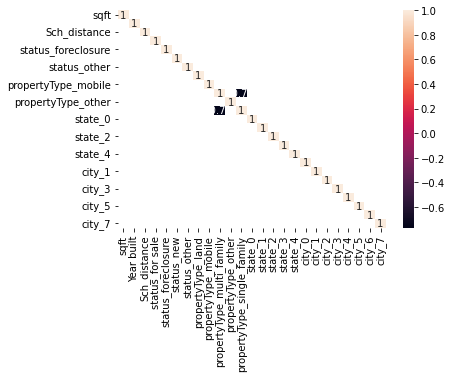

In [58]:
# Проверим признаки на мультиколлинеарность
corr = X_train_scaled.corr()
corr = corr[corr.abs()>0.7]
sns.heatmap(corr, annot = True)

In [59]:
# Из двух признаков с высокой корреляцией оставляем propertyType_multi_family, т.к. он более значим, согласно SelectKBest
X_train_scaled = X_train_scaled.drop('propertyType_single_family', axis = 1)
X_test_scaled = X_test_scaled.drop('propertyType_single_family', axis = 1)

### используем разные модели регрессии (пока не логарифмируя целевую переменную)

In [60]:
# Модель линейной регрессии
lr_model = linear_model.LinearRegression() 

lr_model.fit(X_train_scaled, y_train) #обучение модели
y_train_pred = lr_model.predict(X_train_scaled) #предсказания для обучающей выборки
y_test_pred = lr_model.predict(X_test_scaled) #предсказания для валидационной выборки

print('MAPE на обучающей выборке - {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)))
print('MAPE на тестовой выборке - {:.3f}'.format(metrics. mean_absolute_percentage_error(y_test, y_test_pred)))

MAPE на обучающей выборке - 0.644
MAPE на тестовой выборке - 0.642


In [61]:
# Модель полиномиальной регрессии
poly = PolynomialFeatures(2)
poly.fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)


l2_model = linear_model.Ridge(alpha=0.1)
l2_model.fit(X_train_poly, y_train) #обучение модели
y_train_pred = l2_model.predict(X_train_poly) #предсказания для обучающей выборки
y_test_pred = l2_model.predict(X_test_poly) #предсказания для валидационной выборки

print('MAPE на обучающей выборке - {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)))
print('MAPE на тестовой выборке - {:.3f}'.format(metrics. mean_absolute_percentage_error(y_test, y_test_pred)))

MAPE на обучающей выборке - 0.473
MAPE на тестовой выборке - 0.470


In [62]:
# Решающее дерево
tree_model = tree.DecisionTreeRegressor(random_state = 42)

tree_model.fit(X_train_scaled, y_train) #обучение модели
y_train_pred = tree_model.predict(X_train_scaled) #предсказания для обучающей выборки
y_test_pred = tree_model.predict(X_test_scaled) #предсказания для валидационной выборки

print('MAPE на обучающей выборке - {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)))
print('MAPE на тестовой выборке - {:.3f}'.format(metrics. mean_absolute_percentage_error(y_test, y_test_pred)))


MAPE на обучающей выборке - 0.001
MAPE на тестовой выборке - 0.361


Оптимальная глубина дерева 18, MAPE на обучающей выборке = 0.174, MAPE на тестовой выборке = 0.356


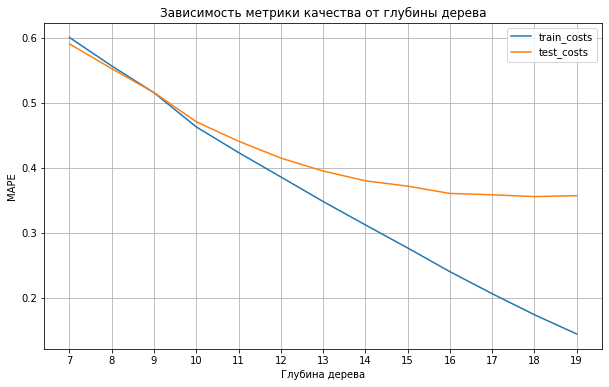

In [63]:
# Учитывая склонность решающих деревьев к переобучению, попробуем определить оптимальную глубину
max_depths = range(7, 20)
train_costs = []
test_costs = []

for depth in max_depths: #организуем цикл для предложенных знычений глубины дерева
    tree_model = tree.DecisionTreeRegressor(max_depth = depth, random_state = 42) #инициализация модели
    tree_model.fit(X_train_scaled, y_train)  #обучение модели
    y_train_pred = tree_model.predict(X_train_scaled) #предсказания для обучающей выборки
    y_test_pred = tree_model.predict(X_test_scaled) #предсказания для валидационной выборки
    train_costs.append(metrics.mean_absolute_percentage_error(y_train, y_train_pred)) #составляем список трен.метрик
    test_costs.append (metrics. mean_absolute_percentage_error(y_test, y_test_pred)) #составляем список валид.метрик

index = np.argmin(test_costs)
print(f'Оптимальная глубина дерева {max_depths[index]}, MAPE на обучающей выборке = {np.round(train_costs[index], 3)}, MAPE на тестовой выборке = {np.round(test_costs[index], 3)}')
#вычисляем оптимальную глубину дерева и соответствующие метрики

fig, ax = plt.subplots(figsize=(10, 6)) #визуализируем оптимальную глубину дерева и соответствующие метрики
ax.plot(max_depths, train_costs, label = 'train_costs')
ax.plot(max_depths, test_costs, label = 'test_costs')
ax.set_title('Зависимость метрики качества от глубины дерева')
ax.set_xlabel("Глубина дерева")
ax.set_ylabel("MAPE")
ax.set_xticks(max_depths)
ax.grid()
ax.legend();

In [64]:
# Модель решающего леса
rf_model = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42,
    n_jobs=-1
    ) #инициализация модели

rf_model.fit(X_train_scaled, y_train)  #обучение модели
y_train_pred = rf_model.predict(X_train_scaled) #предсказания для обучающей выборки
y_test_pred = rf_model.predict(X_test_scaled) #предсказания для валидационной выборки

print('MAPE на обучающей выборке - {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)))
print('MAPE на тестовой выборке - {:.3f}'.format(metrics. mean_absolute_percentage_error(y_test, y_test_pred)))

MAPE на обучающей выборке - 0.380
MAPE на тестовой выборке - 0.399


In [65]:
# Модель градиентного бустинга
gb_model = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42,
) #инициализация модели
gb_model.fit(X_train_scaled, y_train) #обучение модели
y_train_pred = gb_model.predict(X_train_scaled) #предсказания для обучающей выборки
y_test_pred = gb_model.predict(X_test_scaled) #предсказания для валидационной выборки

print('MAPE на обучающей выборке - {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)))
print('MAPE на тестовой выборке - {:.3f}'.format(metrics. mean_absolute_percentage_error(y_test, y_test_pred)))

MAPE на обучающей выборке - 0.339
MAPE на тестовой выборке - 0.364


In [66]:
# Модель экстремального градиентного бустинга

# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train, feature_names=X_train_scaled.columns)
dtest = xgb.DMatrix(X_test_scaled, label=y_test, feature_names=X_train_scaled.columns)

# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dtest, 'test')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

y_train_pred = model.predict(dtrain) #предсказания для обучающей выборки
y_test_pred = model.predict(dtest) #предсказания для валидационной выборки

print('MAPE на обучающей выборке - {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)))
print('MAPE на тестовой выборке - {:.3f}'.format(metrics. mean_absolute_percentage_error(y_test, y_test_pred)))

[0]	train-rmse:384354.40910	test-rmse:385394.35261
[10]	train-rmse:206770.82289	test-rmse:207648.34465
[20]	train-rmse:164393.84048	test-rmse:165360.16826
[30]	train-rmse:152514.17952	test-rmse:153538.59363
[40]	train-rmse:147635.67991	test-rmse:148789.50705
[50]	train-rmse:143211.77536	test-rmse:144507.96044
[60]	train-rmse:140575.85646	test-rmse:142008.02876
[70]	train-rmse:138682.75718	test-rmse:140211.11376
[80]	train-rmse:137241.04625	test-rmse:138887.38671
[90]	train-rmse:135241.81624	test-rmse:137025.39011
[100]	train-rmse:134108.55838	test-rmse:136049.19591
[110]	train-rmse:132626.40581	test-rmse:134722.96645
[120]	train-rmse:131322.36099	test-rmse:133558.90061
[130]	train-rmse:129834.18986	test-rmse:132214.83598
[140]	train-rmse:128863.35868	test-rmse:131376.57562
[150]	train-rmse:128548.91638	test-rmse:131192.51545
[160]	train-rmse:127947.17243	test-rmse:130697.35000
[170]	train-rmse:126802.00422	test-rmse:129683.73332
[180]	train-rmse:126321.07814	test-rmse:129302.31096
[190

### используем те же модели, но только переведем целевую переменную в логарифмическую шкалу

In [67]:
# Модель линейной регрессии

#создаем логарифмированный целевой признак цены
y_train_log = np.log(y_train + 1)


lr_model_log = linear_model.LinearRegression() #инициируем модель с параметрами по умолчанию

lr_model_log.fit(X_train_scaled, y_train_log) #обучение модели
y_train_pred = np.exp(lr_model_log.predict(X_train_scaled)) -1 #предсказания для обучающей выборки
y_test_pred = np.exp(lr_model_log.predict(X_test_scaled)) -1 #предсказания для валидационной выборки

print('MAPE на обучающей выборке - {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)))
print('MAPE на тестовой выборке - {:.3f}'.format(metrics. mean_absolute_percentage_error(y_test, y_test_pred)))


MAPE на обучающей выборке - 0.514
MAPE на тестовой выборке - 0.510


In [68]:
# Модель полиномиальной регрессии
poly = PolynomialFeatures(2)
poly.fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)


l2_model_log = linear_model.Ridge(alpha=0.1)
l2_model_log.fit(X_train_poly, y_train_log) #обучение модели
y_train_pred = np.exp(l2_model_log.predict(X_train_poly)) - 1 #предсказания для обучающей выборки
y_test_pred = np.exp(l2_model_log.predict(X_test_poly)) - 1 #предсказания для валидационной выборки

print('MAPE на обучающей выборке - {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)))
print('MAPE на тестовой выборке - {:.3f}'.format(metrics. mean_absolute_percentage_error(y_test, y_test_pred)))

MAPE на обучающей выборке - 0.388
MAPE на тестовой выборке - 0.386


In [69]:
# Решающее дерево
tree_model_log = tree.DecisionTreeRegressor(random_state = 42)

tree_model_log.fit(X_train_scaled, y_train_log) #обучение модели
y_train_pred = np.exp(tree_model_log.predict(X_train_scaled)) - 1 #предсказания для обучающей выборки
y_test_pred = np.exp(tree_model_log.predict(X_test_scaled)) - 1 #предсказания для валидационной выборки

print('MAPE на обучающей выборке - {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)))
print('MAPE на тестовой выборке - {:.3f}'.format(metrics. mean_absolute_percentage_error(y_test, y_test_pred)))

MAPE на обучающей выборке - 0.001
MAPE на тестовой выборке - 0.346


Оптимальная глубина дерева 16, MAPE на обучающей выборке = 0.218, MAPE на тестовой выборке = 0.329


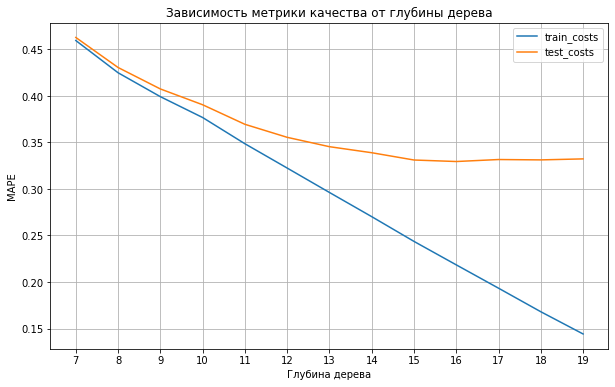

In [70]:
# Учитывая склонность решающих деревьев к переобучению, попробуем определить оптимальную глубину
max_depths = range(7, 20)
train_costs = []
test_costs = []

for depth in max_depths: #организуем цикл для предложенных знычений глубины дерева
    tree_model_log = tree.DecisionTreeRegressor(max_depth = depth, random_state = 42) #инициализация модели
    tree_model_log.fit(X_train_scaled, y_train_log)  #обучение модели
    y_train_pred = np.exp(tree_model_log.predict(X_train_scaled)) - 1 #предсказания для обучающей выборки
    y_test_pred = np.exp(tree_model_log.predict(X_test_scaled)) - 1 #предсказания для валидационной выборки
    train_costs.append(metrics.mean_absolute_percentage_error(y_train, y_train_pred)) #составляем список трен.метрик
    test_costs.append (metrics. mean_absolute_percentage_error(y_test, y_test_pred)) #составляем список валид.метрик

index = np.argmin(test_costs)
print(f'Оптимальная глубина дерева {max_depths[index]}, MAPE на обучающей выборке = {np.round(train_costs[index], 3)}, MAPE на тестовой выборке = {np.round(test_costs[index], 3)}')
#вычисляем оптимальную глубину дерева и соответствующие метрики

fig, ax = plt.subplots(figsize=(10, 6)) #визуализируем оптимальную глубину дерева и соответствующие метрики
ax.plot(max_depths, train_costs, label = 'train_costs')
ax.plot(max_depths, test_costs, label = 'test_costs')
ax.set_title('Зависимость метрики качества от глубины дерева')
ax.set_xlabel("Глубина дерева")
ax.set_ylabel("MAPE")
ax.set_xticks(max_depths)
ax.grid()
ax.legend();

In [71]:
# Модель решающего леса
rf_model_log = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42,
    n_jobs=-1
    ) #инициализация модели

rf_model_log.fit(X_train_scaled, y_train_log)  #обучение модели
y_train_pred = np.exp(rf_model_log.predict(X_train_scaled)) - 1 #предсказания для обучающей выборки
y_test_pred =np.exp(rf_model_log.predict(X_test_scaled)) - 1 #предсказания для валидационной выборки

print('MAPE на обучающей выборке - {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)))
print('MAPE на тестовой выборке - {:.3f}'.format(metrics. mean_absolute_percentage_error(y_test, y_test_pred)))

MAPE на обучающей выборке - 0.311
MAPE на тестовой выборке - 0.329


In [72]:
# Модель градиентного бустинга

gb_model_log = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42,
) #инициализация модели
gb_model_log.fit(X_train_scaled, y_train_log) #обучение модели
y_train_pred = np.exp(gb_model_log.predict(X_train_scaled)) - 1 #предсказания для обучающей выборки
y_test_pred = np.exp(gb_model_log.predict(X_test_scaled)) - 1 #предсказания для валидационной выборки

print('MAPE на обучающей выборке - {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)))
print('MAPE на тестовой выборке - {:.3f}'.format(metrics. mean_absolute_percentage_error(y_test, y_test_pred)))

MAPE на обучающей выборке - 0.282
MAPE на тестовой выборке - 0.307


In [73]:
# Модель экстремального градиентного бустинга
y_test_log = np.log(y_test + 1)
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=X_train_scaled.columns)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_log, feature_names=X_train_scaled.columns)

# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dtest, 'test')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

y_train_pred = np.exp(model.predict(dtrain)) - 1 #предсказания для обучающей выборки
y_test_pred = np.exp(model.predict(dtest)) - 1 #предсказания для валидационной выборки

print('MAPE на обучающей выборке - {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)))
print('MAPE на тестовой выборке - {:.3f}'.format(metrics. mean_absolute_percentage_error(y_test, y_test_pred)))

[0]	train-rmse:10.87806	test-rmse:10.88290
[10]	train-rmse:3.82609	test-rmse:3.82844
[20]	train-rmse:1.41161	test-rmse:1.41260
[30]	train-rmse:0.66041	test-rmse:0.66169
[40]	train-rmse:0.48247	test-rmse:0.48475
[50]	train-rmse:0.44767	test-rmse:0.45105
[60]	train-rmse:0.43731	test-rmse:0.44143
[70]	train-rmse:0.43024	test-rmse:0.43488
[80]	train-rmse:0.42463	test-rmse:0.42963
[90]	train-rmse:0.42099	test-rmse:0.42652
[100]	train-rmse:0.41492	test-rmse:0.42093
[110]	train-rmse:0.40948	test-rmse:0.41599
[120]	train-rmse:0.40719	test-rmse:0.41421
[130]	train-rmse:0.40399	test-rmse:0.41134
[140]	train-rmse:0.39962	test-rmse:0.40746
[150]	train-rmse:0.39768	test-rmse:0.40611
[160]	train-rmse:0.39492	test-rmse:0.40382
[170]	train-rmse:0.39097	test-rmse:0.40041
[180]	train-rmse:0.38755	test-rmse:0.39741
[190]	train-rmse:0.38611	test-rmse:0.39641
[200]	train-rmse:0.38427	test-rmse:0.39483
[210]	train-rmse:0.38311	test-rmse:0.39407
[220]	train-rmse:0.38053	test-rmse:0.39199
[230]	train-rmse:0.3

### Наилучшие результаты показали ансамблевые модели. Попробуем оптимизировать гиперпараметры для некоторых из них

In [74]:
# Подбор гиперпараметров для RandomForestRegressor с кросс-валидацией
random_state=42
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 10)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
 

  # создаем модель
  rf_model_log = ensemble.RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель с кросс-валидацией
  score = model_selection.cross_val_score(estimator=rf_model_log, cv=5, X = X_train_scaled, y = y_train_log, scoring='neg_mean_absolute_percentage_error').mean()
   
  return score

In [75]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-08-10 17:32:18,275] A new study created in memory with name: RandomForestClassifier
[I 2023-08-10 17:40:49,822] Trial 0 finished with value: -0.021932146541790813 and parameters: {'n_estimators': 180, 'max_depth': 16, 'min_samples_leaf': 9}. Best is trial 0 with value: -0.021932146541790813.
[I 2023-08-10 17:48:29,827] Trial 1 finished with value: -0.02041671997388246 and parameters: {'n_estimators': 130, 'max_depth': 25, 'min_samples_leaf': 5}. Best is trial 1 with value: -0.02041671997388246.
[I 2023-08-10 17:57:24,093] Trial 2 finished with value: -0.024092143072050203 and parameters: {'n_estimators': 200, 'max_depth': 12, 'min_samples_leaf': 5}. Best is trial 1 with value: -0.02041671997388246.
[I 2023-08-10 18:06:06,900] Trial 3 finished with value: -0.021416181881353673 and parameters: {'n_estimators': 160, 'max_depth': 26, 'min_samples_leaf': 10}. Best is trial 1 with value: -0.02041671997388246.
[I 2023-08-10 18:11:17,551] Trial 4 finished with value: -0.022051531117728

CPU times: total: 2h 30min 22s
Wall time: 2h 34min 42s


In [76]:
# рассчитаем точность для тестовой выборки
rf_model_log = ensemble.RandomForestRegressor(**study.best_params,random_state=random_state)
rf_model_log.fit(X_train_scaled, y_train_log)
y_train_pred = np.exp(rf_model_log.predict(X_train_scaled)) - 1
y_test_pred = np.exp(rf_model_log.predict(X_test_scaled)) - 1

print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print('MAPE на обучающей выборке - {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)))
print('MAPE на тестовой выборке - {:.3f}'.format(metrics. mean_absolute_percentage_error(y_test, y_test_pred)))

Наилучшие значения гиперпараметров {'n_estimators': 130, 'max_depth': 30, 'min_samples_leaf': 2}
MAPE на обучающей выборке - 0.121
MAPE на тестовой выборке - 0.254


In [77]:
# Подбор гиперпараметров для GradientBoostingRegressor
random_state=42
def optuna_gbr(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 2, 10, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  learning_rate = trial.suggest_float(name = 'learning_rate', low = 0.01, high = 1, step = 0.05)

  # создаем модель
  gb_model_log = ensemble.GradientBoostingRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          learning_rate = learning_rate,
                                          random_state=random_state)
  # обучаем модель с кросс-валидацией
  score = model_selection.cross_val_score(estimator=gb_model_log, cv=5, X = X_train_scaled, y = y_train_log, scoring='neg_mean_absolute_percentage_error').mean()
   
  return score
 

In [78]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="GradientBoostingRegressor", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_gbr, n_trials=20)

[I 2023-08-10 20:09:29,163] A new study created in memory with name: GradientBoostingRegressor


c:\Users\Asus-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:701: UserWarning: The distribution is specified by [0.01, 1] and step=0.05, but the range is not divisible by `step`. It will be replaced by [0.01, 0.96].
  warnings.warn(
[I 2023-08-10 20:12:07,036] Trial 0 finished with value: -0.03670442875598025 and parameters: {'n_estimators': 101, 'max_depth': 4, 'min_samples_leaf': 9, 'learning_rate': 0.01}. Best is trial 0 with value: -0.03670442875598025.
c:\Users\Asus-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:701: UserWarning: The distribution is specified by [0.01, 1] and step=0.05, but the range is not divisible by `step`. It will be replaced by [0.01, 0.96].
  warnings.warn(
[I 2023-08-10 20:22:09,280] Trial 1 finished with value: -0.021627605990901137 and parameters: {'n_estimators': 197, 'max_depth': 10, 'min_samples_leaf': 2, 'learning_rate': 0.46}. Best is trial 1 with value: -0.021627605990901137.

CPU times: total: 1h 54min 16s
Wall time: 9h 36min 13s


In [79]:
# рассчитаем точность для тестовой выборки
gb_model_log = ensemble.GradientBoostingRegressor(**study.best_params, random_state=random_state)
gb_model_log.fit(X_train_scaled, y_train_log)
y_train_pred = np.exp(gb_model_log.predict(X_train_scaled)) - 1
y_test_pred = np.exp(gb_model_log.predict(X_test_scaled)) - 1

print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print('MAPE на обучающей выборке - {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)))
print('MAPE на тестовой выборке - {:.3f}'.format(metrics. mean_absolute_percentage_error(y_test, y_test_pred)))

Наилучшие значения гиперпараметров {'n_estimators': 153, 'max_depth': 10, 'min_samples_leaf': 5, 'learning_rate': 0.21000000000000002}
MAPE на обучающей выборке - 0.189
MAPE на тестовой выборке - 0.270


### Наилучшие результаты показала модель RandomForestRegressor с параметрами, подобранными с помощью Optuna и кросс-валидации

In [80]:
# Производим сериализацию и записываем результат в файл формата pkl
with open('model.pkl', 'wb') as output:
    pickle.dump(rf_model_log, output)

In [83]:
!pip freeze > requirements.txt